In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

from pyseis.wave_equations import acoustic_isotropic
from pyseis.wavelets.acoustic import Acoustic2D
from pyseis import inversion
import plotting

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


## Helper functions

In [115]:
def make_random_model(shape,seed=112,min_vel=2000,max_vel=3000):
    n_x, n_z = shape
    np.random.seed(seed)

    v_p = min_vel + (max_vel-min_vel) * np.random.rand(n_z)
    v_p = ndimage.gaussian_filter(v_p,1)
    v_p = myround(v_p,10)
    
    return np.ones((n_x,n_z)) * v_p
    
def myround(x, base=5):
    return (base * (np.array(x) / base).round())

def plot_data(data,
              d_t,
              src_locations=None,
              rec_locations=None,
              n_shots=6,
              title='wavelet',
              figsize=(3, 5),
              pclip=99,
              clip=None,
              cmap='gray',
              ylabel='time (s)',
              xlabel='rec positions (m)'):
  fig, axs = plt.subplots(1,
                          n_shots,
                          figsize=(figsize[0] * n_shots, figsize[1]))

  skip = data.shape[0] // n_shots
  data = data[::skip]
  if src_locations is not None:
    src_locations = src_locations[::skip]
  if rec_locations is None:
    rec_locations = np.arange(data.shape[1])
    xlabel = 'rec #'

  t_axis = d_t * np.arange(data.shape[-1])

  if clip is None:
    clip = np.percentile(np.abs(data), pclip)
  for i, (ax, shot) in enumerate(zip(axs, data)):
    ax.pcolormesh(rec_locations,
                  t_axis,
                  shot.T,
                  shading='nearest',
                  vmin=-clip,
                  vmax=clip,
                  cmap=cmap)
    ax.invert_yaxis()
    if src_locations is None:
      ax.set_title(f'shot# {i*skip}')
    else:
      ax.set_title(f'shot pos %.2f' % src_locations[i])

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

## Make "random" 1.5d model and src/rec geometry

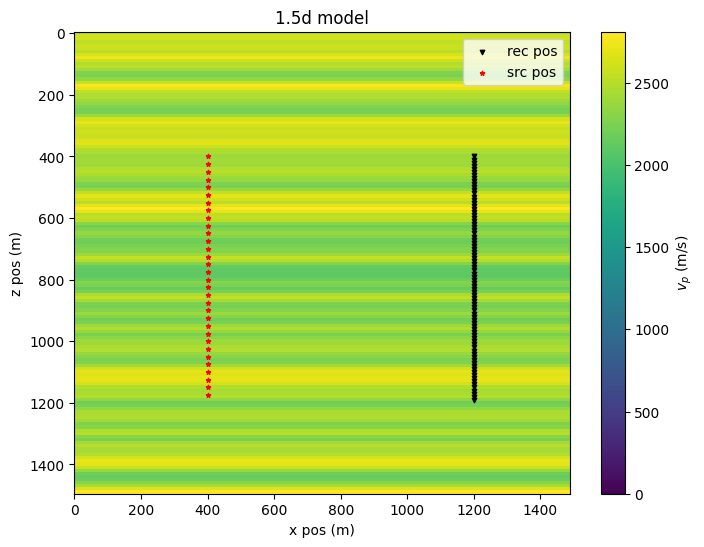

In [108]:
n_x = n_z = 150
d_x = d_z = 10.0

#create model
true_model = make_random_model((n_x,n_z))

# create source and receiver geometry
rec_top_depth = 400.0
rec_bot_depth = 1200.0
rec_spacing = 10.0
rec_x_pos = 1200.0
z_rec = np.arange(rec_top_depth,rec_bot_depth,rec_spacing)
x_rec = rec_x_pos * np.ones_like(z_rec) 
recs = np.array([x_rec, z_rec]).T

src_top_depth = 400.0
src_bot_depth = 1200.0
src_spacing = 25.0
src_x_pos = 400.0
z_src = np.arange(src_top_depth,src_bot_depth,src_spacing)
x_src = src_x_pos * np.ones_like(z_src) 
srcs = np.array([x_src, z_src]).T

#plot 
plotting.plot_model(true_model,
                   title='1.5d model', 
                   cbar=True,
                   sampling=(d_x,d_z),
                   cmap='viridis',
                   src_locations=srcs,
                   rec_locations=recs,
                   figsize=(8,6))

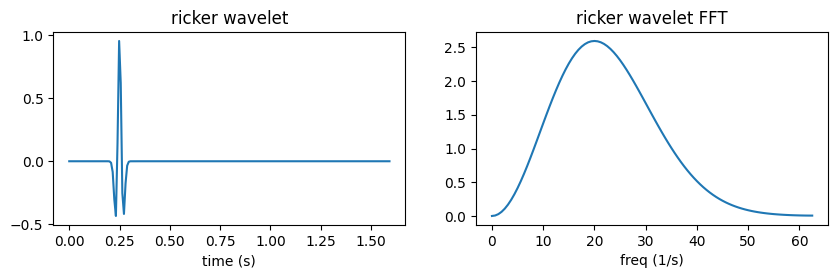

In [109]:
# make a Ricker wavelet
n_t = 200
d_t = 0.008
dom_freq = 20.0
delay = 0.25
ricker = Acoustic2D.AcousticIsotropicRicker2D(n_t, d_t, dom_freq, delay).arr

plotting.plot_wavelet(ricker,d_t,title='ricker wavelet')

In [110]:
# make 2d acoustic wave equation solver
acoustic_2d = acoustic_isotropic.AcousticIsotropic2D(
  model=true_model,
  model_sampling=(d_x,d_z),
  model_padding=(50, 50),
  wavelet=ricker,
  d_t=d_t,
  src_locations=srcs,
  rec_locations=recs,
  gpus=[0,1,2,3])

CPU times: user 1.64 s, sys: 364 ms, total: 2.01 s
Wall time: 342 ms


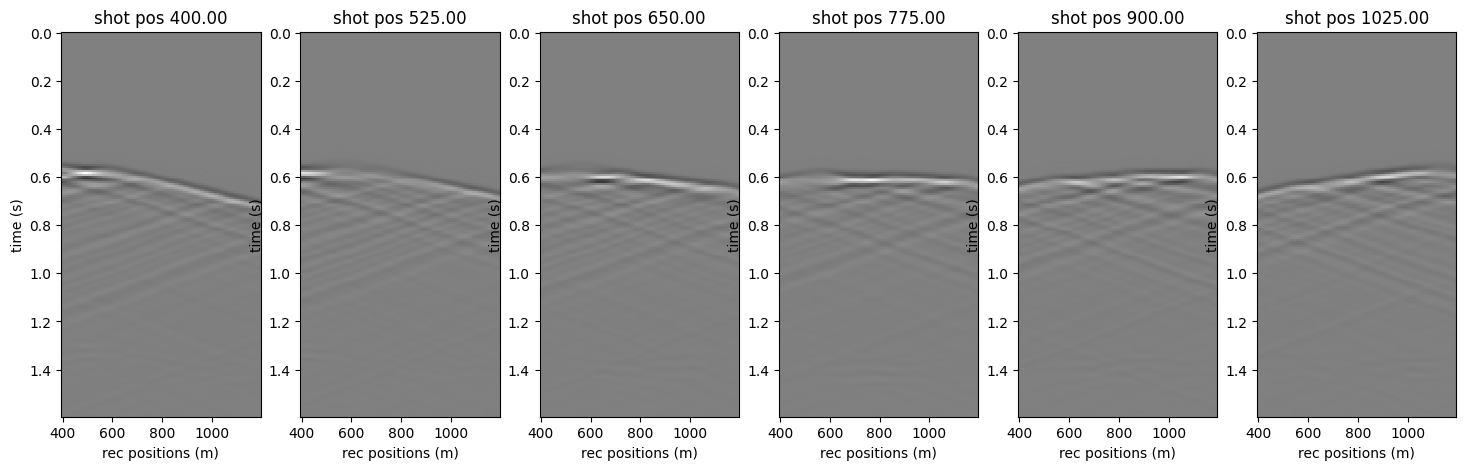

In [114]:
%%time
data_obs = acoustic_2d.forward(true_model)

plot_data(data_obs,
          d_t,
          src_locations=z_src,
          rec_locations=z_rec,
          pclip=100)

## make FWI starting model

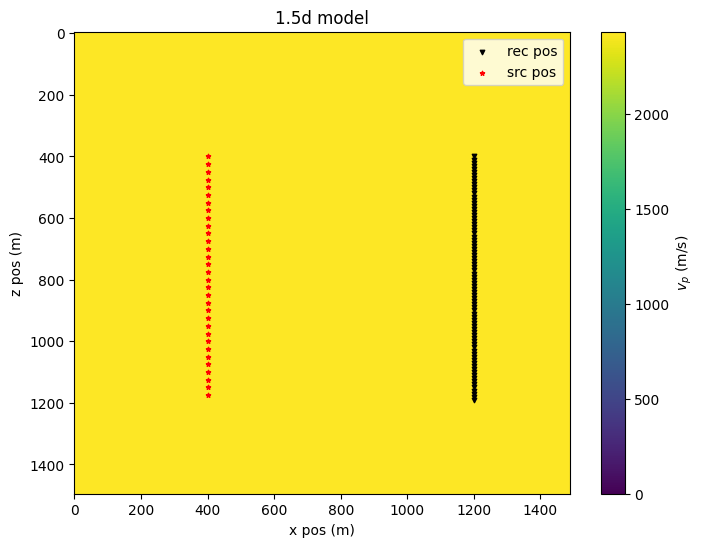

In [118]:
starting_model = np.ones(true_model.shape) * np.mean(true_model)

plotting.plot_model(starting_model,
                   title='1.5d model', 
                   cbar=True,
                   sampling=(d_x,d_z),
                   cmap='viridis',
                   src_locations=srcs,
                   rec_locations=recs,
                   figsize=(8,6))

In [125]:
fwi_prob = inversion.Fwi(acoustic_2d,
                         data_obs,
                         starting_model,
                         num_iter=50,
                         iterations_per_save=5,
                        prefix='crosswell')

In [126]:
%%time

history = fwi_prob.run()

##########################################################################################
Broyden-Fletcher-Goldfarb-Shanno (BFGS) algorithm 
Restart folder: /tmp/restart_2023-01-12T03-40-08.818380/
##########################################################################################

iter = 00, obj = 3.36876e+04, resnorm = 2.60e+02, gradnorm = 3.07e+00, feval = 1, geval = 1
iter = 01, obj = 1.59735e+04, resnorm = 1.79e+02, gradnorm = 1.92e+00, feval = 4, geval = 2
iter = 02, obj = 1.06394e+04, resnorm = 1.46e+02, gradnorm = 1.87e+00, feval = 7, geval = 3
iter = 03, obj = 6.81554e+03, resnorm = 1.17e+02, gradnorm = 1.23e+00, feval = 10, geval = 4
iter = 04, obj = 4.62217e+03, resnorm = 9.61e+01, gradnorm = 1.01e+00, feval = 13, geval = 5
iter = 05, obj = 2.61195e+03, resnorm = 7.23e+01, gradnorm = 8.15e-01, feval = 16, geval = 6
iter = 06, obj = 1.60833e+03, resnorm = 5.67e+01, gradnorm = 5.77e-01, feval = 19, geval = 7
iter = 07, obj = 1.02545e+03, resnorm = 4.53e+01, gradnorm = 

## Plot objective function as a function of iteration

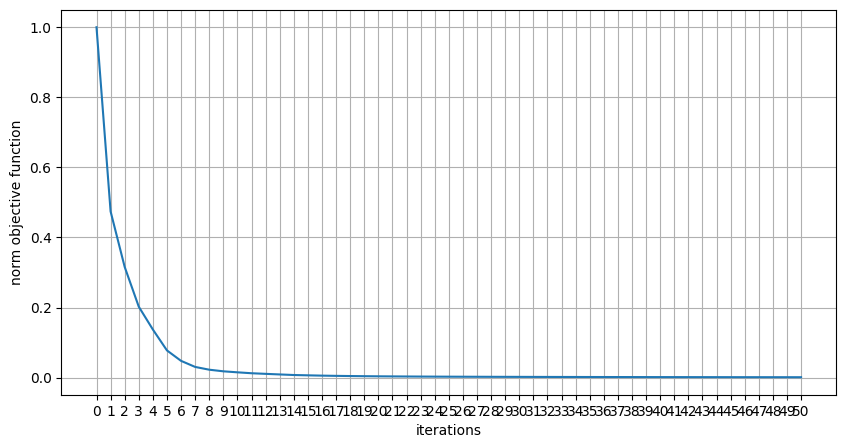

In [129]:
obj_func = history['obj']

fig, ax = plt.subplots(1,figsize=(10,5))
ax.plot(obj_func/obj_func.max())
_ = ax.set_xlabel('iterations')
_ = ax.set_ylabel('norm objective function')
_ = ax.set_xticks(np.arange(len(obj_func)))
ax.grid()

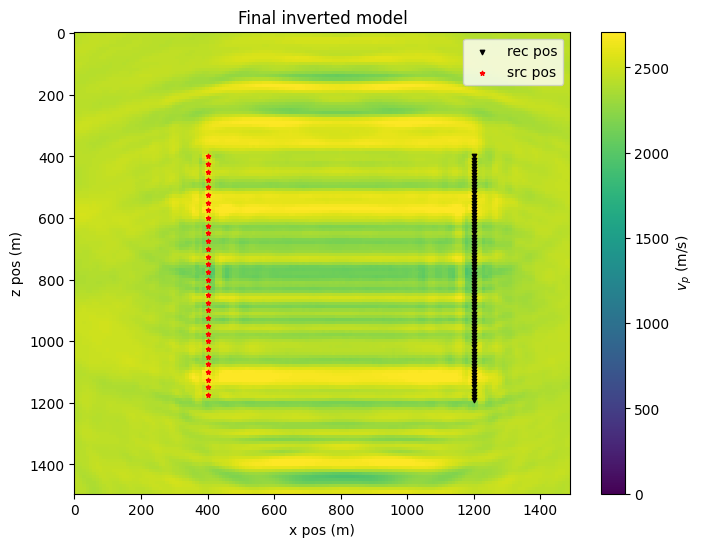

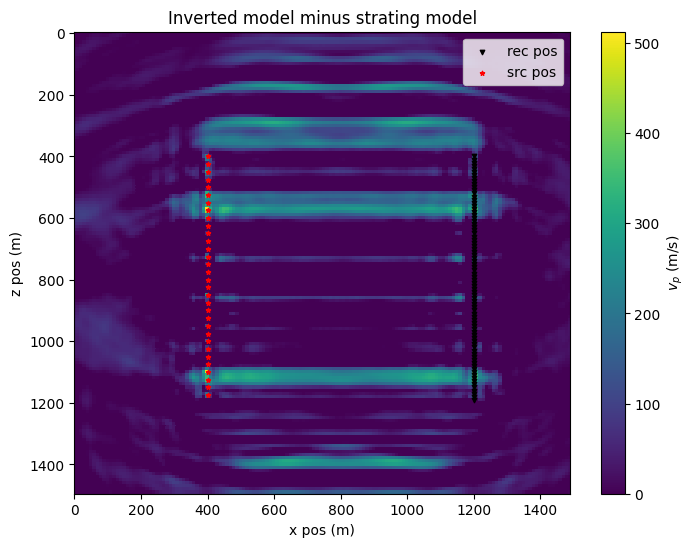

In [130]:
plotting.plot_model(history['inv_mod'],
                   title='Final inverted model',
                   cbar=True,
                   sampling=(d_x,d_z),
                   cmap='viridis',
                   src_locations=srcs,
                   rec_locations=recs,
                   figsize=(8,6))

plotting.plot_model(history['inv_mod']-starting_model,
           title='Inverted model minus strating model',
           cbar=True,
           sampling=(d_x,d_z),
           cmap='viridis',
           src_locations=srcs,
           rec_locations=recs,
           figsize=(8,6),
           pclip=100)

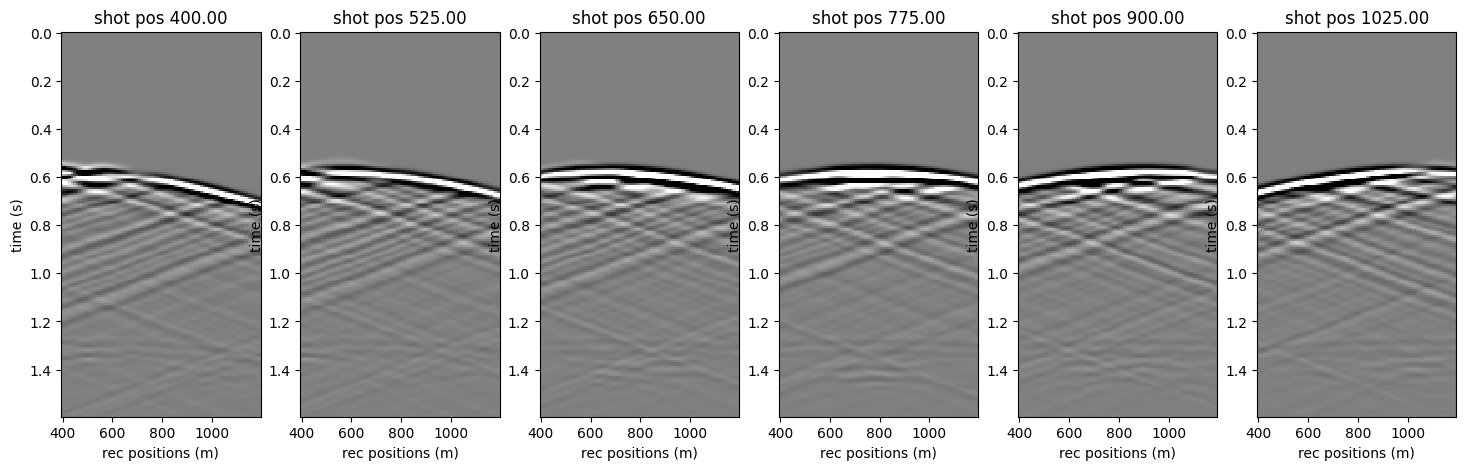

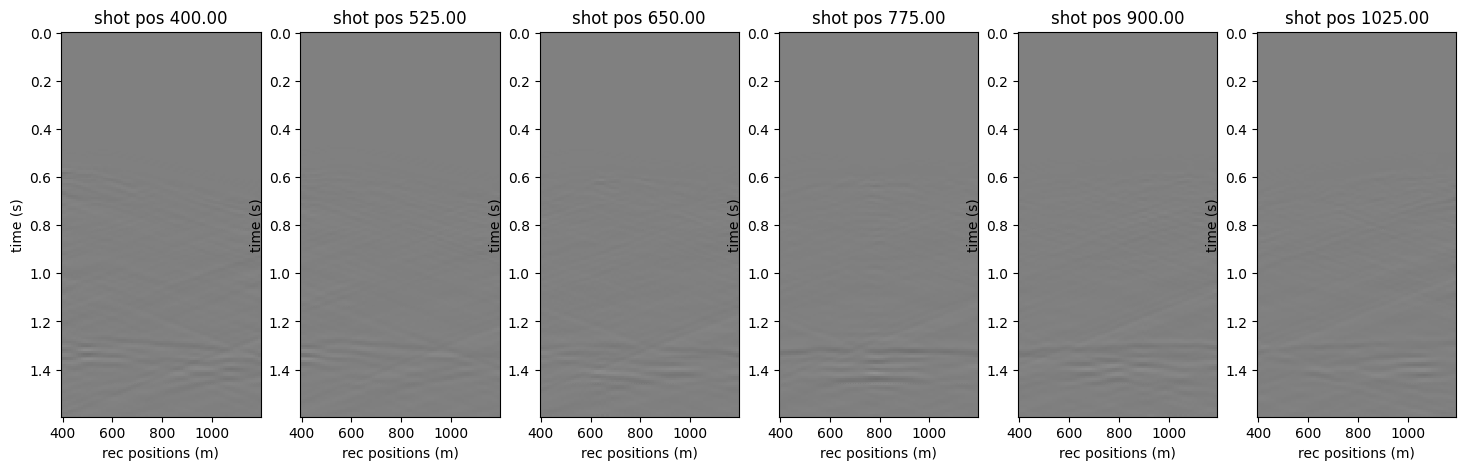

In [131]:
clip = np.percentile(data_obs,99)

#first residual
plot_data(history['residual'][0],
          d_t,
          src_locations=z_src,
          rec_locations=z_rec,
          clip=clip)

#final residual
plot_data(history['residual'][-1],
          d_t,
          src_locations=z_src,
          rec_locations=z_rec,
          clip=clip)